In [1]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="",
    project_name="general",
    workspace="",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/dnlmy/general/bf01f5b01e9d4e188444f248d5bdc803



In [2]:
import torch
from torch import nn
from torch.optim import SGD
import w1d4_tests
import numpy as np
import matplotlib.pyplot as plt
import gin

In [3]:
fname = 'small_moon.jpg'
data_train, data_test =  w1d4_tests.load_image(fname)

dir(data_train.dataset)
data_train.dataset.__len__()

8192

In [4]:
class OurNet(nn.Module):
    def __init__(self, P, H, K):
        super(OurNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(P, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, K)
        )
    
    def forward(self, x):
        return self.layers(x)
    

In [7]:
on = OurNet(2, 400, 3)

In [8]:
w1d4_tests.test_mlp(OurNet)

Congrats! You've passed the test.


In [9]:
gin.enter_interactive_mode()

@gin.configurable
def train(model, dataloader, lr, momentum):
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum)
    # optimizer = RMSPROP(model.parameters(), 0.0002, 0.001, 0.001, 0, 0.7)
    
    loss_function = nn.L1Loss()

    model.train()

    for i, data in enumerate(dataloader):
        inputs, target = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, target)

        loss.backward()
        
        optimizer.step()

        #print("loss: ", loss.item())

    return model

if __name__ == "__main__":
    with gin.unlock_config():
        gin.parse_config_file(config_file="config.gin")
        train(on, data_train)

In [10]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/dnlmy/general/bf01f5b01e9d4e188444f248d5bdc803
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7] : (0.22129066288471222, 0.3018226623535156)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (9.82 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET IN

In [691]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [669]:
from torch import mean
import torch as t

def evaluate(model, dataloader):
    model.eval()
    loss_function = nn.L1Loss()

    losses = []

    for i, data in enumerate(dataloader):
        inputs, target = data


        outputs = model(inputs)

        loss = loss_function(outputs, target)

        losses.append(loss)

    return float(mean(t.tensor(losses)))


In [670]:
#w1d4_tests.test_evaluate(evaluate)

In [678]:
class OurNet2(nn.Module):
    def __init__(self, P, H, K):
        super(OurNet2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(P, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, K)
        )
    
    def forward(self, x):
        return self.layers(x)
    

In [679]:
on = OurNet2(2, 600, 3)

In [680]:
epochs = 100

train_losses = []
test_losses = []

for epoch in range(epochs):

    print("epoch: ", epoch)

    train_losses.append(evaluate(on, data_train))
    test_losses.append(evaluate(on, data_train))

    on = train(on, data_train)#, lr = 0.01, momentum= 0.7)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

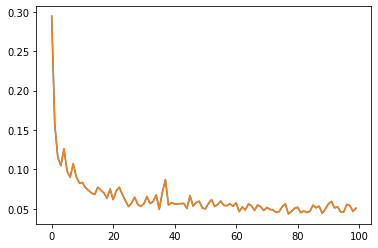

In [682]:
from matplotlib import pyplot as pyplot

plt.plot(train_losses)
plt.plot(test_losses)

plt.show()

In [683]:
xy_pairs = []

for x in t.arange(-0.5,0.5,1/256):
    for y in t.arange(-0.5,0.5,1/256):
        xy_pairs.append((float(x),float(y)))

xy_pairs = t.tensor(xy_pairs)


In [684]:
guess = on(xy_pairs)

In [685]:
guess.shape
guess = guess.reshape(256, 256,3)
guess = guess + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


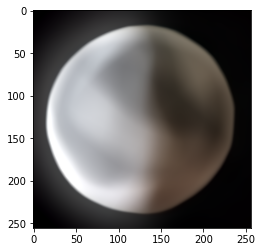

In [686]:
plt.imshow(guess.detach().numpy())

In [368]:
print(t.max(guess))

tensor(0.3846, grad_fn=<MaxBackward1>)


In [369]:
print(t.min(guess))

tensor(-0.0101, grad_fn=<MinBackward1>)


In [370]:
def rosenbrock(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1


f(0, 0)

2

In [371]:
x = np.linspace(-2.0, 2.0, 100)
y = np.linspace(-1.0, 3.0, 100)

X, Y = np.meshgrid(x, y)

result = rosenbrock(X, Y, a=1, b=100)

print(X.flatten())
print(Y.flatten())

[-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
  2.        ]
[-1. -1. -1. ...  3.  3.  3.]


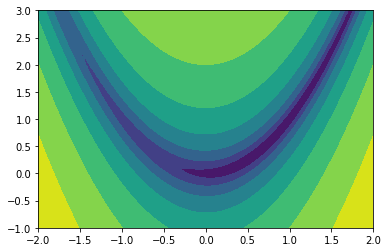

In [372]:
plt.contourf(X, Y, np.log(result))

In [373]:
class XY(nn.Module):
    def __init__(self, xy):
        super(XY, self).__init__()
        (x, y) = xy
        self.register_parameter(name='x', param=nn.Parameter(x))
        self.register_parameter(name='y', param=nn.Parameter(y))
    
    def forward(self):
        return (x, y)

In [374]:
def opt_rosenbrock(xy, lr, momentum, n_iter):
    xy = XY(xy)
    optimizer = SGD(xy.parameters(), lr, momentum)
    loss_function = nn.L1Loss()

    xy.train()

    result = t.zeros((n_iter+1, 2))

    for i in range(n_iter+1):
        optimizer.zero_grad()

        output = rosenbrock(xy.get_parameter("x"),xy.get_parameter("y"))

        loss = loss_function(output, t.tensor(0))

        loss.backward()
        optimizer.step()

        result[i] = t.tensor([xy.get_parameter("x"), xy.get_parameter('y')])

    return result

In [375]:
w1d4_tests.test_rosenbrock(opt_rosenbrock)


Testing configuration:  {'lr': 0.001, 'momentum': 0.0, 'n_iter': 10}
Your module returns different results from the example solution.

Testing configuration:  {'lr': 0.001, 'momentum': 0.8, 'n_iter': 20}
Your module returns different results from the example solution.


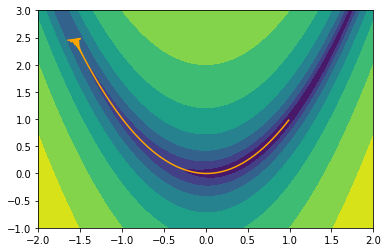

In [391]:
traj = opt_rosenbrock(t.tensor([-1.5, 2.5]), lr=0.001, momentum=0.8, n_iter=2000)

plt.contourf(X, Y, np.log(result))
plt.plot(traj[:,0], traj[:,1], color='orange')
plt.show()

In [392]:
np.min(result)

1.0001030714254164

In [393]:
rosenbrock(traj[-1,0],traj[-1,1])

tensor(1.0001)

In [558]:
from torch.optim import Optimizer

class SGD(Optimizer):
    def __init__(self, params, lr, momentum=0, dampening=0, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay

        self.t = 1
        self.b_tm1 = [None for _ in range(len(self.params))]
        

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):

        with torch.no_grad():

            for i, param in enumerate(self.params):
                
                g_t = param.grad

                if self.weight_decay != 0:
                    g_t = g_t + self.weight_decay * param.data

                if self.momentum != 0:
                    if self.t > 1:
                        b_t = self.momentum * self.b_tm1[i] + (1-self.dampening)*g_t
                    else:
                        b_t = g_t

                    g_t = b_t

                    self.b_tm1[i] = b_t

                param -= self.lr * g_t

            self.t += 1

            return self.params


In [559]:
    w1d4_tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [560]:
from torch.optim import Optimizer

class RMSPROP(Optimizer):
    def __init__(self, params, lr, alpha = 0.99, eps=0, weight_decay=0, momentum = 0):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.eps = eps
        self.weight_decay = weight_decay
        self.alpha = alpha

        self.b_tm1 = [0. for _ in range(len(self.params))]
        self.v_tm1 = [0. for _ in range(len(self.params))]

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                
                g_t = param.grad

                if self.weight_decay != 0:
                    g_t = g_t + self.weight_decay * param.data

                self.v = self.alpha * self.v_tm1[i] + (1- self.alpha) * g_t ** 2


                if self.momentum > 0:
                     
                    b_t = self.momentum * self.b_tm1[i] + g_t/(self.v ** 0.5 + self.eps)
                    param -= self.lr * b_t
                    self.b_tm1[i] = b_t
                else:
                    param -= self.lr * g_t / (self.v ** 0.5 + self.eps)

                self.v_tm1[i] = self.v
                


            return self.params

In [561]:
w1d4_tests.test_rmsprop(RMSPROP)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [562]:
from torch.optim import Optimizer

class Adam(Optimizer):
    def __init__(self, params, lr, betas, eps, weight_decay):
        self.params = list(params)
        self.b1, self.b2 = betas
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay

        self.t = 1

        self.m_tm1 = [0. for _ in range(len(self.params))]
        self.v_tm1 = [0. for _ in range(len(self.params))]

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                
                g_t = param.grad

                if self.weight_decay != 0:
                    g_t = g_t + self.weight_decay * param.data

                m = self.b1 * self.m_tm1[i] + (1 - self.b1) * g_t
                v = self.b2 * self.v_tm1[i] + (1- self.b2) * g_t ** 2

                m_h = m / (1 - self.b1 ** self.t)
                v_h = v / (1 - self.b2 ** self.t)

                param -= self.lr * m_h / (v_h ** 0.5 + self.eps)

                self.m_tm1[i] = m
                self.v_tm1[i] = v
                
            self.t += 1

            return self.params

In [563]:
w1d4_tests.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [580]:
xy = t.tensor([-1.5, 2.5])

def opt_rosenbrock_sgd(xy, lr, momentum, n_iter):
    xy = XY(xy)
    optimizer = SGD(xy.parameters(), lr, momentum)
    loss_function = nn.L1Loss()

    xy.train()

    result = t.zeros((n_iter+1, 2))

    for i in range(n_iter+1):
        optimizer.zero_grad()

        output = rosenbrock(xy.get_parameter("x"),xy.get_parameter("y"))

        loss = loss_function(output, t.tensor(0))

        loss.backward()
        optimizer.step()

        result[i] = t.tensor([xy.get_parameter("x"), xy.get_parameter('y')])

    return result


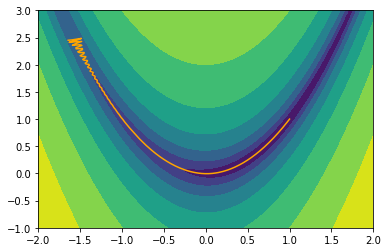

In [581]:
traj = opt_rosenbrock_sgd(xy, 0.001, 0.9, 2000)

plt.contourf(X, Y, np.log(result))
plt.plot(traj[:,0], traj[:,1], color='orange')
plt.show()

In [ ]:
our_rmsprop = RMSPROP(xy.parameters(), 0.001, 0.99, 0)
our_adam = Adam(xy.parameters(), 0.001, [0.001, 0.001], 0.001, 0)

In [609]:
xy = t.tensor([-1.5, 2.5])

def opt_rosenbrock_rmsprop(xy, lr, alpha, eps, weight_decay, momentum, n_iter):
    xy = XY(xy)
    optimizer = RMSPROP(xy.parameters(), lr, alpha, eps, weight_decay, momentum)
    loss_function = nn.L1Loss()

    xy.train()

    result = t.zeros((n_iter+1, 2))

    for i in range(n_iter+1):
        optimizer.zero_grad()

        output = rosenbrock(xy.get_parameter("x"),xy.get_parameter("y"))

        loss = loss_function(output, t.tensor(0))

        loss.backward()
        optimizer.step()

        result[i] = t.tensor([xy.get_parameter("x"), xy.get_parameter('y')])

    return result

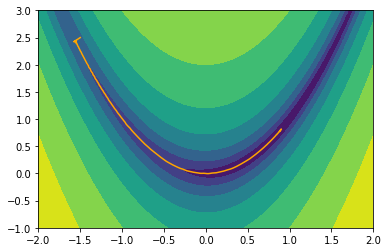

In [610]:
traj = opt_rosenbrock_rmsprop(xy, 0.001, 0.001, 0.001, 0, 0.9, 500)

plt.contourf(X, Y, np.log(result))
plt.plot(traj[:,0], traj[:,1], color='orange')
plt.show()

In [601]:
xy = t.tensor([-1.5, 2.5])

def opt_rosenbrock_adam(xy, lr, betas, eps, weight_decay, n_iter):
    xy = XY(xy)
    optimizer = Adam(xy.parameters(), lr, betas, eps, weight_decay)
    loss_function = nn.L1Loss()

    xy.train()

    result = t.zeros((n_iter+1, 2))

    for i in range(n_iter+1):
        optimizer.zero_grad()

        output = rosenbrock(xy.get_parameter("x"),xy.get_parameter("y"))

        loss = loss_function(output, t.tensor(0))

        loss.backward()
        optimizer.step()

        result[i] = t.tensor([xy.get_parameter("x"), xy.get_parameter('y')])

    return result

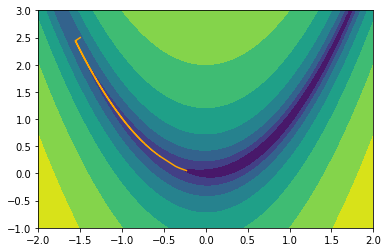

In [602]:
traj = opt_rosenbrock_adam(xy, 0.001, (0.001, 0.001), 1e-8, 0.9, 2500)

plt.contourf(X, Y, np.log(result))
plt.plot(traj[:,0], traj[:,1], color='orange')
plt.show()

In [47]:
def make_grid(possible_values):
    a = possible_values.values()
    pvs = list(itertools.product(*a))

    ld = []
    for pv in pvs:
        dict = {}
        for e, key in enumerate(possible_values.keys()):
            dict[key] = pv[e]
        ld.append(dict)

    return ld

In [48]:
import itertools
a = np.array([3,6,5,2])

In [49]:
d = {
    "lr" : [0.01, 0.02, 0.03],
    "momentum" : [0.7,0.8],
    "beta" : [0.1,0.2,0.3,0.4]
}

In [50]:
a = d.values()
pvs = list(itertools.product(*a))

In [51]:
ld = []
for pv in pvs:
    dict = {}
    for e, key in enumerate(d.keys()):
        dict[key] = pv[e]
    ld.append(dict)

ld



[{'lr': 0.01, 'momentum': 0.7, 'beta': 0.1},
 {'lr': 0.01, 'momentum': 0.7, 'beta': 0.2},
 {'lr': 0.01, 'momentum': 0.7, 'beta': 0.3},
 {'lr': 0.01, 'momentum': 0.7, 'beta': 0.4},
 {'lr': 0.01, 'momentum': 0.8, 'beta': 0.1},
 {'lr': 0.01, 'momentum': 0.8, 'beta': 0.2},
 {'lr': 0.01, 'momentum': 0.8, 'beta': 0.3},
 {'lr': 0.01, 'momentum': 0.8, 'beta': 0.4},
 {'lr': 0.02, 'momentum': 0.7, 'beta': 0.1},
 {'lr': 0.02, 'momentum': 0.7, 'beta': 0.2},
 {'lr': 0.02, 'momentum': 0.7, 'beta': 0.3},
 {'lr': 0.02, 'momentum': 0.7, 'beta': 0.4},
 {'lr': 0.02, 'momentum': 0.8, 'beta': 0.1},
 {'lr': 0.02, 'momentum': 0.8, 'beta': 0.2},
 {'lr': 0.02, 'momentum': 0.8, 'beta': 0.3},
 {'lr': 0.02, 'momentum': 0.8, 'beta': 0.4},
 {'lr': 0.03, 'momentum': 0.7, 'beta': 0.1},
 {'lr': 0.03, 'momentum': 0.7, 'beta': 0.2},
 {'lr': 0.03, 'momentum': 0.7, 'beta': 0.3},
 {'lr': 0.03, 'momentum': 0.7, 'beta': 0.4},
 {'lr': 0.03, 'momentum': 0.8, 'beta': 0.1},
 {'lr': 0.03, 'momentum': 0.8, 'beta': 0.2},
 {'lr': 0.

In [52]:
d2 = {
  "train.lr":          np.geomspace(1e-1, 1e-3, 3),
  "Model.hidden_size": [768, 1024],
}

make_grid(d2)

[{'train.lr': 0.1, 'Model.hidden_size': 768},
 {'train.lr': 0.1, 'Model.hidden_size': 1024},
 {'train.lr': 0.01, 'Model.hidden_size': 768},
 {'train.lr': 0.01, 'Model.hidden_size': 1024},
 {'train.lr': 0.001, 'Model.hidden_size': 768},
 {'train.lr': 0.001, 'Model.hidden_size': 1024}]

In [39]:
np.geomspace(1e-1, 1e-3, 3)

array([0.1  , 0.01 , 0.001])